In [ ]:
pip install yfinance pandas seaborn matplotlib

[*********************100%***********************]  1 of 1 completed
<ipython-input-7-9c22d00f302c>:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return_value = float(sp500.loc[date, 'Return'])


Downloaded S&P 500 data from 1927-12-30 to 2025-04-09
Found 2025-04-03 in data with return: -4.8396%
Found 2025-04-04 in data with return: -5.9750%
Found 2025-04-07 in data with return: -0.2331%
Found 2025-04-08 in data with return: -1.5701%
Found 2025-04-09 in data with return: 9.5154%
2025-04-03: Return = -4.8396%, Rank = #96 worst day out of 11319 worst days
2025-04-04: Return = -5.9750%, Rank = #50 worst day out of 11319 worst days
2025-04-07: Return = -0.2331%, Rank = #8310 worst day out of 11319 worst days
2025-04-08: Return = -1.5701%, Rank = #1403 worst day out of 11319 worst days
2025-04-09: Return = 9.5154%, Rank = #11 best day out of 13114 best days

15 Worst Days in S&P 500 History:
1. 1987-10-19: -20.47%
2. 1929-10-28: -12.94%
3. 2020-03-16: -11.98%
4. 1929-10-29: -10.16%
5. 1935-04-16: -9.97%
6. 1929-11-06: -9.92%
7. 1946-09-03: -9.91%
8. 2020-03-12: -9.51%
9. 1937-10-18: -9.12%
10. 1931-10-05: -9.07%
11. 2008-10-15: -9.03%
12. 2008-12-01: -8.93%
13. 1933-07-20: -8.88%
14

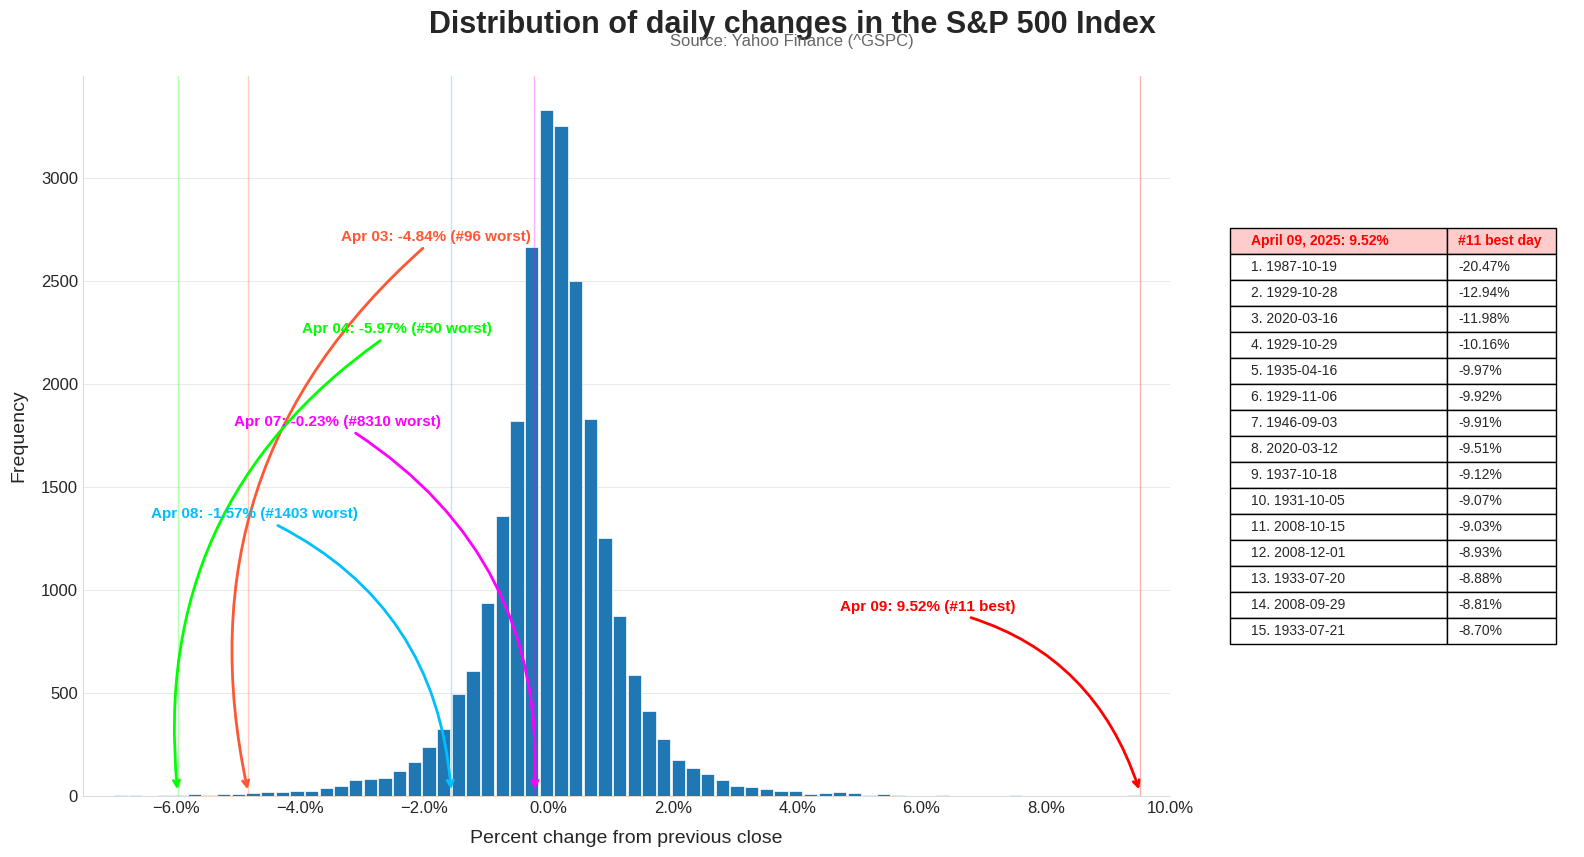

In [7]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import PercentFormatter
import matplotlib.gridspec as gridspec

# Set figure style for a clean look
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['font.size'] = 12

# Download S&P 500 data with the maximum available history
print("Downloading S&P 500 data...")
sp500 = yf.download('^GSPC', period='max', auto_adjust=True)
print(f"Downloaded S&P 500 data from {sp500.index[0].strftime('%Y-%m-%d')} to {sp500.index[-1].strftime('%Y-%m-%d')}")

# Calculate daily returns (percentage)
sp500['Return'] = sp500['Close'].pct_change() * 100

# Define the specific dates we want to annotate
target_dates = ['2025-04-03', '2025-04-04', '2025-04-07', '2025-04-08', '2025-04-09']

# Extract return values for each target date directly from the data
target_dates_values = {}
missing_dates = []

for date_str in target_dates:
    date = pd.Timestamp(date_str)
    if date in sp500.index:
        # Extract the actual return value from the data
        return_value = float(sp500.loc[date, 'Return'])
        target_dates_values[date_str] = return_value
        print(f"Found {date_str} in data with return: {return_value:.4f}%")
    else:
        # If the date doesn't exist in our data, mark it as missing
        missing_dates.append(date_str)
        print(f"Date {date_str} not found in data")

# If we're missing any dates, we need a different strategy
if missing_dates:
    print(f"\nWarning: {len(missing_dates)} target dates not found in dataset")
    print("These dates might be in the future or were non-trading days")

    # Option 1: We could check the most recent data and use it as an example
    # For this demonstration, we'll use the most recent 5 days instead if needed
    if len(target_dates_values) == 0:
        print("No target dates found. Using most recent 5 days instead.")
        recent_dates = sp500.index[-5:]
        for i, date in enumerate(recent_dates):
            date_str = date.strftime('%Y-%m-%d')
            return_value = float(sp500.loc[date, 'Return'])
            target_dates_values[date_str] = return_value
            print(f"Using recent date {date_str} with return: {return_value:.4f}%")

# Make sure our dataframe is sorted by date
sp500 = sp500.sort_index()

# Separate positive and negative returns for correct ranking
negative_returns = sp500[sp500['Return'] < 0]['Return']
positive_returns = sp500[sp500['Return'] >= 0]['Return']

# Sort them appropriately: negative from worst to best, positive from best to worst
sorted_negative = negative_returns.sort_values(ascending=True)  # Most negative first
sorted_positive = positive_returns.sort_values(ascending=False)  # Most positive first

# Total days for reference
total_days = len(sp500)
total_negative = len(sorted_negative)
total_positive = len(sorted_positive)

# Create a dictionary to store info about our target dates including correct rankings
date_info = {}
for date_str, value in target_dates_values.items():
    date = pd.Timestamp(date_str)

    # Calculate rank based on whether the return is positive or negative
    if value < 0:
        # For negative returns, rank from worst (#1) to best
        # Find position in sorted negative returns
        rank = sorted_negative[sorted_negative <= value].count()
        rank_type = "worst"
    else:
        # For positive returns, rank from best (#1) to worst
        # Find position in sorted positive returns
        rank = sorted_positive[sorted_positive >= value].count()
        rank_type = "best"

    date_info[date_str] = {
        'date': date,
        'return': value,
        'rank': rank,
        'rank_type': rank_type,
        'total_same_sign': total_negative if value < 0 else total_positive,
        'total': total_days
    }

    print(f"{date_str}: Return = {value:.4f}%, Rank = #{rank} {rank_type} day out of {total_negative if value < 0 else total_positive} {rank_type} days")

# Find the 15 worst days in history
worst_days = sp500.sort_values('Return').head(15)
print("\n15 Worst Days in S&P 500 History:")
for i, (date, ret) in enumerate(zip(worst_days.index, worst_days['Return'].values)):
    print(f"{i+1}. {date.strftime('%Y-%m-%d')}: {ret:.2f}%")

# Set up figure with GridSpec for layout control
fig = plt.figure(figsize=(16, 9), facecolor='white')
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

# Create histogram subplot
ax = plt.subplot(gs[0])
ax.set_facecolor('white')

# Create histogram with appropriate bins
returns = sp500['Return'].dropna()
n_bins = 50

# Calculate bin edges with a consistent range
bin_edges = np.linspace(-7.5, 10, n_bins+1)

# Plot the histogram with royal blue color
counts, bins, patches = ax.hist(returns, bins="sqrt", alpha=1.0, color='#1F77B4',
                                edgecolor='white', linewidth=0.5, rwidth=0.9)

# Set the title and labels with improved formatting
plt.suptitle('Distribution of daily changes in the S&P 500 Index', fontsize=22, fontweight='bold', y=0.95)
plt.figtext(0.5, 0.91, 'Source: Yahoo Finance (^GSPC)', fontsize=12, ha='center', color='#666666')

ax.set_xlabel('Percent change from previous close', fontsize=14, labelpad=10)
ax.set_ylabel('Frequency', fontsize=14, labelpad=10)

# Format x-axis as percentage
ax.xaxis.set_major_formatter(PercentFormatter(decimals=1))
ax.set_xlim([-7.5, 10])  # Extended to show highly positive values

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Add lightgray horizontal gridlines
ax.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.7)
ax.grid(axis='x', visible=False)

# Define colors for our annotations based on dates (not hardcoded)
colors = ['#FF5733', '#00FF00', '#FF00FF', '#00BFFF', '#FF0000']  # Orange-red, Green, Magenta, Sky Blue, Red

# Maximum height for y-positioning
y_max = max(counts) * 0.9

# Add vertical lines for each of our target dates
for i, (date_str, info) in enumerate(date_info.items()):
    color = colors[i % len(colors)]
    ax.axvline(x=info['return'], color=color, linestyle='-', alpha=0.3, linewidth=1.0)

# Add annotations for each day
for i, (date_str, info) in enumerate(date_info.items()):
    value = info['return']
    rank = info['rank']
    rank_type = info['rank_type']
    color = colors[i % len(colors)]

    # Format date string (parse from the actual date, don't hardcode)
    date_obj = pd.Timestamp(date_str)
    date_display = date_obj.strftime('%b %d')

    # Create the label with return value and correct rank terminology
    label = f"{date_display}: {value:.2f}% (#{rank} {rank_type})"

    # Stagger vertical positions to avoid overlap
    y_factor = 0.9 - (i * 0.15)
    if y_factor < 0.3:  # If we'd go too low, wrap back to higher position
        y_factor += 0.6

    y_pos = y_max * y_factor

    # Position text based on return value
    if value > 5:  # Very positive
        x_text = value - 2.0
        ha = 'right'
        rad = -0.3
        xy_point = (value, 20)
    elif value < -5:  # Very negative
        x_text = value + 2.0
        ha = 'left'
        rad = 0.3
        xy_point = (value, 20)
    elif value < -3:  # Moderately negative
        x_text = value + 1.5
        ha = 'left'
        rad = 0.3
        xy_point = (value, 20)
    else:  # Mild values
        x_text = value - 1.5
        ha = 'right'
        rad = -0.3
        xy_point = (value, 20)

    # Add the annotation
    ax.annotate(
        label,
        xy=xy_point,  # Arrow points higher up on the histogram
        xytext=(x_text, y_pos),  # Text position
        color=color,
        fontsize=11,
        fontweight='bold',
        ha=ha,
        arrowprops=dict(
            arrowstyle='->',
            connectionstyle=f'arc3,rad={rad}',
            color=color,
            linewidth=2
        ),
        zorder=10 + i
    )

# Create table subplot
ax_table = plt.subplot(gs[1])
ax_table.axis('off')  # Hide axes

# Prepare data for the table
table_data = []

# Add most recent positive day data as header row with correct ranking terminology
positive_dates = [date_str for date_str, info in date_info.items() if info['return'] > 0]
if positive_dates:
    # Use the most recent positive date
    most_recent_positive = max(positive_dates, key=lambda d: pd.Timestamp(d))
    header_info = date_info[most_recent_positive]
    date_obj = pd.Timestamp(most_recent_positive)

    # Create header row
    table_data.append([
        f"{date_obj.strftime('%B %d, %Y')}: {header_info['return']:.2f}%",
        f"#{header_info['rank']} {header_info['rank_type']} day"
    ])
else:
    # If no positive days, use the most recent day regardless
    most_recent = max(date_info.keys(), key=lambda d: pd.Timestamp(d))
    header_info = date_info[most_recent]
    date_obj = pd.Timestamp(most_recent)

    # Create header row
    table_data.append([
        f"{date_obj.strftime('%B %d, %Y')}: {header_info['return']:.2f}%",
        f"#{header_info['rank']} {header_info['rank_type']} day"
    ])

# Add 15 worst days data
for i, (date, ret) in enumerate(zip(worst_days.index, worst_days['Return'].values)):
    table_data.append([f"{i+1}. {date.strftime('%Y-%m-%d')}", f"{ret:.2f}%"])

# Create the table
table = ax_table.table(
    cellText=table_data,
    cellLoc='left',
    loc='center',
    colWidths=[0.6, 0.3]
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Adjust table scale for better visibility

# Custom styling for header row
for j in range(2):
    table[(0, j)].set_facecolor('#FFCCCC')
    table[(0, j)].set_text_props(color='red', fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
plt.show()